<a href="https://colab.research.google.com/github/MayarQasrawi/Image_classifier_with_Tensorflow/blob/main/Image_Classifier_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Resources

In [1]:
# TODO: Make all necessary imports.

import warnings
warnings.filterwarnings('ignore')
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import logging
import time
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator

logger = tf.get_logger()
logger.setLevel(logging.ERROR)
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.17.0
	• tf.keras version: 3.4.1
	• Running on GPU


# Load the Dataset

Here you'll use `tensorflow_datasets` to load the **Oxford Flowers 102 dataset**. This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`. You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [2]:
# TODO: Load the dataset with TensorFlow Datasets
dataset, data_info= tfds.load('oxford_flowers102',as_supervised=True,with_info=True) # Remove the space in the dataset name
# TODO: Create a training set, a validation set and a test set.
Training_dataset, Validation_dataset, Test_dataset = dataset['train'], dataset['validation'], dataset['test']

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


#Explore the Dataset

In [3]:
data_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

In [4]:
# TODO: Get the number of examples in each set from the dataset info.
splits = ['train', 'test', 'validation']

#to show each split in the dataset
for s in splits:
    print('The split {} has {} records'.format(s, data_info.splits[s].num_examples))

total_number_of_examples = data_info.splits['train'].num_examples

# TODO: Get the number of classes in the dataset from the dataset info.
num_classes = data_info.features['label'].num_classes
print("Number of Classes is: ", num_classes)

The split train has 1020 records
The split test has 6149 records
The split validation has 1020 records
Number of Classes is:  102


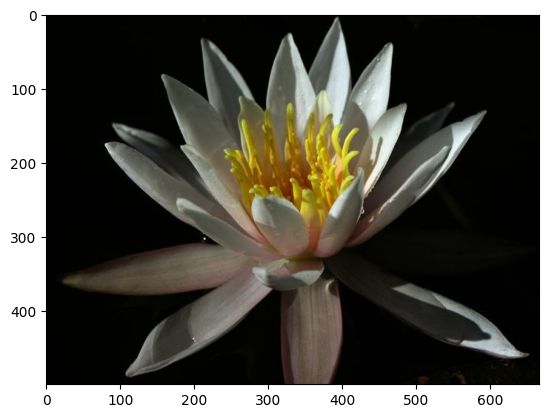

The shape of this image is: (500, 667, 3)
The label of this image is: 72


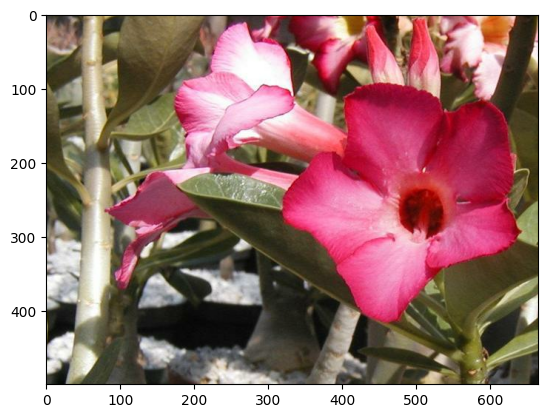

The shape of this image is: (500, 666, 3)
The label of this image is: 84


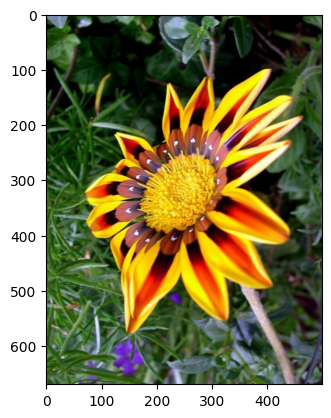

The shape of this image is: (670, 500, 3)
The label of this image is: 70


In [5]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for image, label in Training_dataset.take(3):
    image = image.numpy().squeeze()  #.squeeze() is not importarnt here
    label = label.numpy()

    plt.imshow(image)
    plt.show()

    print('The shape of this image is:', image.shape)
    print('The label of this image is:', label)

Text(0.5, 1.0, '72')

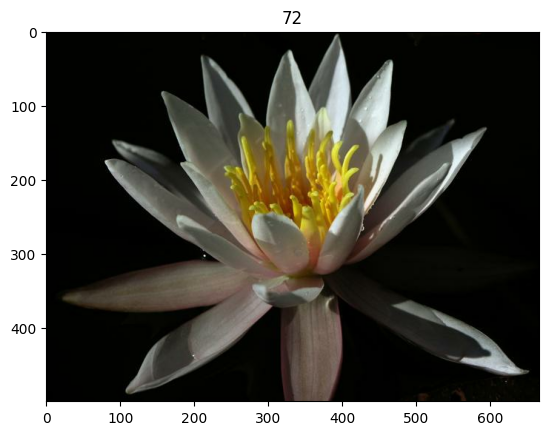

In [6]:
# TODO: Plot 1 image from the training set. Set the title
# of the plot to the corresponding image label.
for img, label  in Training_dataset.take(1):
  img = img.numpy().squeeze()  #.squeeze() is not importarnt here
  label = label.numpy()

plt.imshow(img)
plt.title(label)

# Label Mapping
You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the json module. This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

0 pink primrose
1 hard-leaved pocket orchid
2 canterbury bells
3 sweet pea
4 english marigold
5 tiger lily
6 moon orchid
7 bird of paradise
8 monkshood
9 globe thistle
10 snapdragon
11 colt's foot
12 king protea
13 spear thistle
14 yellow iris
15 globe-flower
16 purple coneflower
17 peruvian lily
18 balloon flower
19 giant white arum lily
20 fire lily
21 pincushion flower
22 fritillary
23 red ginger
24 grape hyacinth
25 corn poppy
26 prince of wales feathers
27 stemless gentian
28 artichoke
29 sweet william
30 carnation
31 garden phlox
32 love in the mist
33 mexican aster
34 alpine sea holly
35 ruby-lipped cattleya
36 cape flower
37 great masterwort
38 siam tulip
39 lenten rose
40 barbeton daisy
41 daffodil
42 sword lily
43 poinsettia
44 bolero deep blue
45 wallflower
46 marigold
47 buttercup
48 oxeye daisy
49 common dandelion
50 petunia
51 wild pansy
52 primula
53 sunflower
54 pelargonium
55 bishop of llandaff
56 gaura
57 geranium
58 orange dahlia
59 pink-yellow dahlia?
60 cautleya sp

Text(0.5, 1.0, 'water lily')

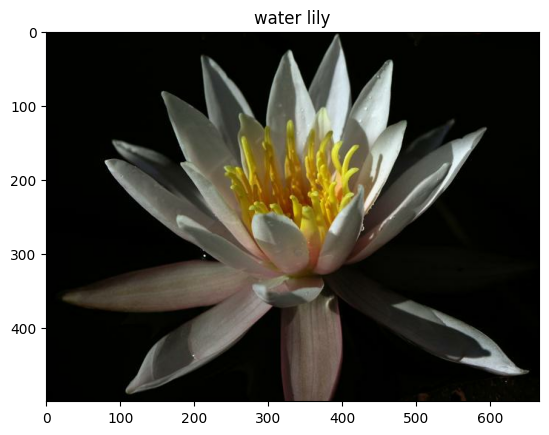

In [7]:
with open('/content/label_map.json', 'r') as f:
    class_names = json.load(f)
#show the class_name
for num, label in class_names.items():
    print(num,label)
# TODO: Plot 1 image from the training set. Set the title
# of the plot to the corresponding class name.
for img, label  in Training_dataset.take(1):
  img = img.numpy()
  label = label.numpy()

plt.imshow(img)
plt.title(class_names[str(label)])

# Create Pipeline

In [8]:
# TODO: Create a pipeline for each set.

batch_size = 32
image_size = 224
train_split = 60

def preprocess(image, label):
  # Resize to --> (224x224)
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (image_size , image_size))
  # Normalize pixel values between 0 and 1
  image = image / 255
  return image, label
# num_training_examples = data_info.splits['train'].num_examples
# print("Number of training examples: {}".format(num_training_examples))
# print(total_number_of_examples)



training_batches = Training_dataset.cache().shuffle(total_number_of_examples//4).map(preprocess).batch(batch_size).prefetch(1)
testing_batches = Test_dataset.cache().map(preprocess).batch(batch_size).prefetch(1) # Apply preprocessing before batching
validation_batches = Validation_dataset.cache().map(preprocess).batch(batch_size).prefetch(1)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students!

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model.

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [17]:
# TODO: Build and train your network.
import tf_keras
tf.keras.backend.clear_session()
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"


feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))
feature_extractor.trainable = False


model = tf_keras.Sequential()
model.add(feature_extractor)


layer_nodes= [ 1024]
rate=0.07
for neurons in layer_nodes:
    model.add(tf_keras.layers.Dense(neurons, activation='relu'))
    model.add(tf_keras.layers.Dropout(rate))


model.add(tf_keras.layers.Dense(num_classes, activation='softmax'))
# print(num_classes)
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
EPOCHS = 10
# Train the model
history = model.fit( training_batches,
                    epochs=EPOCHS,
                    validation_data= validation_batches)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 102)               104550    
                                                                 
Total params: 3674278 (14.02 MB)
Trainable params: 1416294 (5.40 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 6s 97ms/step - loss: 3.6307 - accuracy: 0.2676 - val_loss: 1.9437 - val_accuracy: 0.6216
Epoc

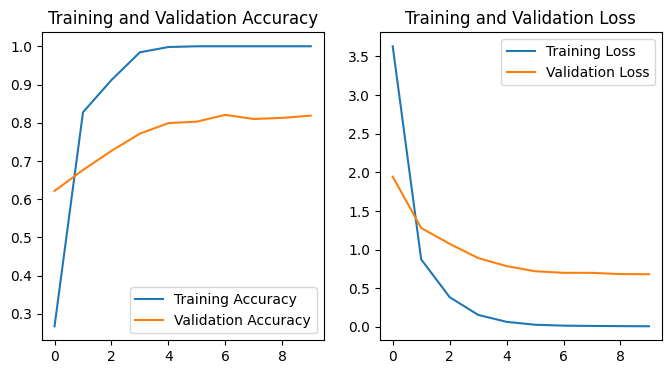

In [18]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(EPOCHS)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Testing your Network
It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [19]:
# TODO: Print the loss and accuracy values achieved on the entire test set.

loss, accuracy = model.evaluate(testing_batches)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

193/193 [==============================] - 7s 36ms/step - loss: 0.8187 - accuracy: 0.7902

Loss on the TEST Set: 0.819
Accuracy on the TEST Set: 79.021%


# Save the Model
Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (i.e. save it as an HDF5 file).

In [20]:

model.save("my_flower_classifier.h5")

# Load the Keras Model
Load the Keras model you saved above.


In [21]:
loaded_Model= tf_keras.models.load_model("my_flower_classifier.h5",custom_objects={'KerasLayer':hub.KerasLayer})
loaded_Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 102)               104550    
                                                                 
Total params: 3674278 (14.02 MB)
Trainable params: 1416294 (5.40 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like:

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function.

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values.

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [14]:
# TODO: Create the process_image function
def process_image(image):
    image_size = 224
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    image = image.numpy().squeeze()
    return image

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size.

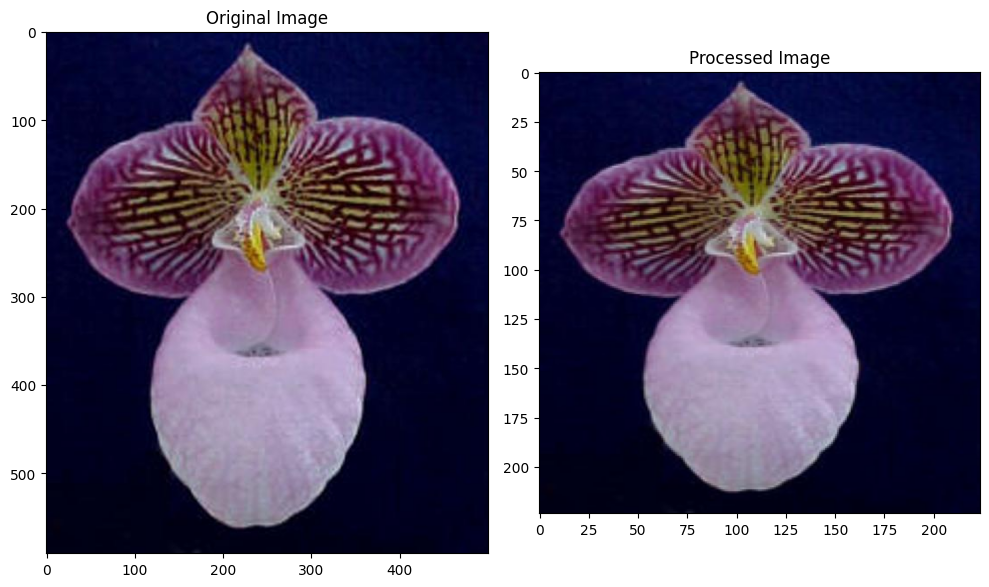

In [22]:
from PIL import Image

image_path = '/content/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like:

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension.

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:
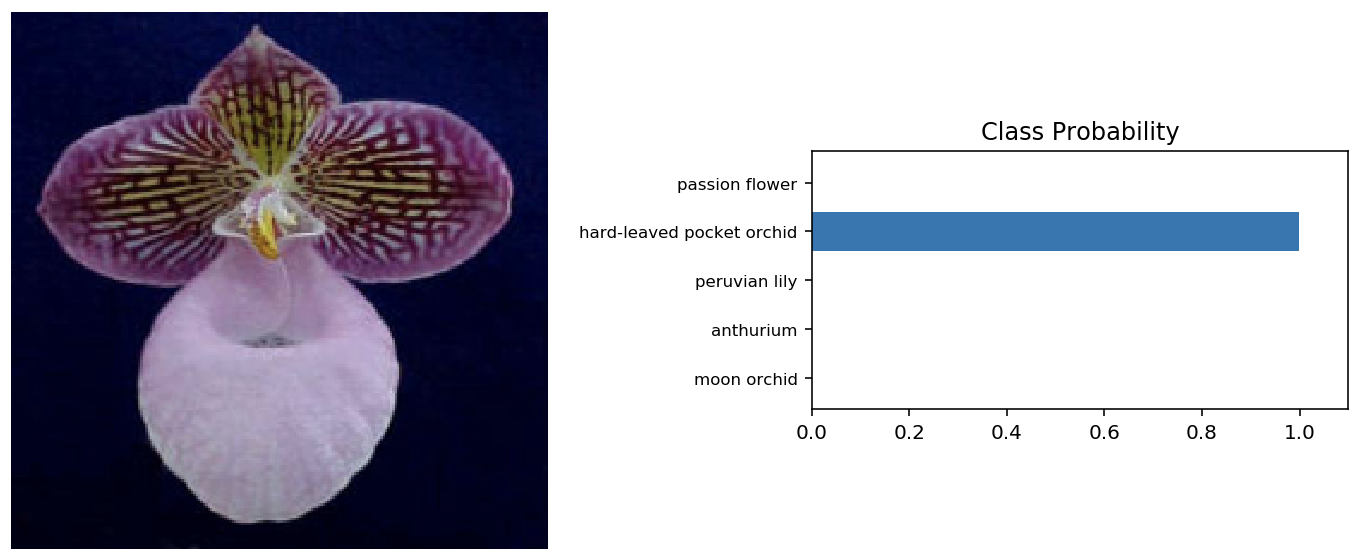

You can convert from the class integer labels to actual flower names using `class_names`.

1/1 [==============================] - 0s 448ms/step
[3.797520912485197e-05, 4.323858593124896e-05, 6.614800076931715e-05, 0.00011095224908785895, 0.9995760321617126]
['Tree poppy', 'Giant white arum lily', 'Californian poppy', 'Alpine sea holly', 'Primula']
[(3.797520912485197e-05, 'Tree poppy'), (4.323858593124896e-05, 'Giant white arum lily'), (6.614800076931715e-05, 'Californian poppy'), (0.00011095224908785895, 'Alpine sea holly'), (0.9995760321617126, 'Primula')]


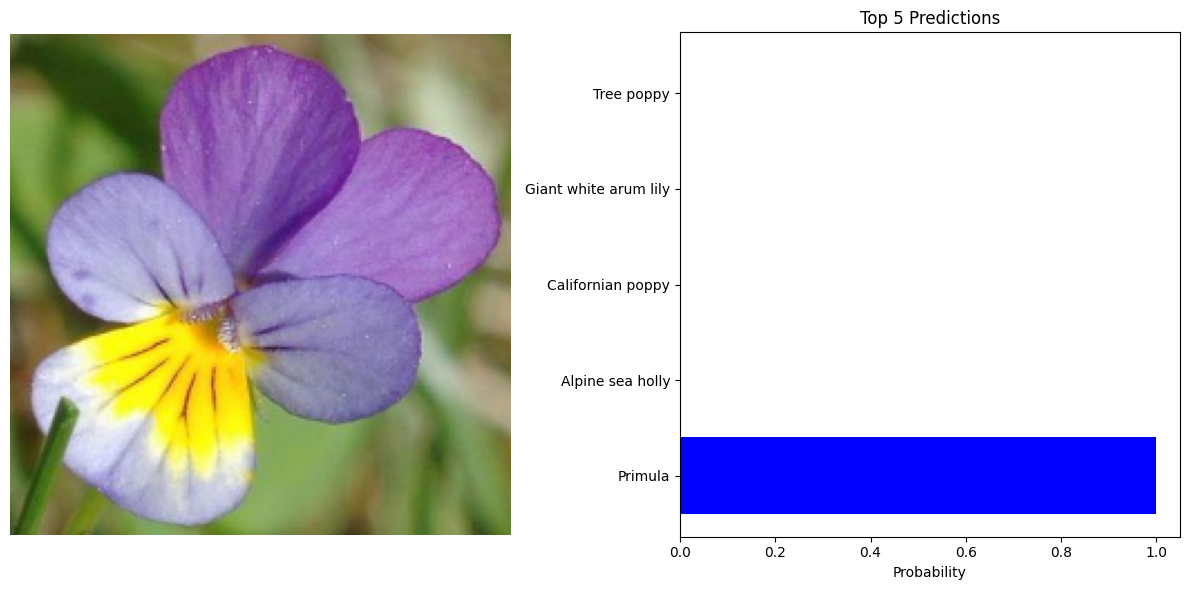

1/1 [==============================] - 0s 33ms/step
[0.008963045664131641, 0.00989934429526329, 0.017106231302022934, 0.40997910499572754, 0.5098828673362732]
['Daffodil', 'Pink-yellow dahlia?', 'Trumpet creeper', 'Tiger lily', 'Azalea']
[(0.008963045664131641, 'Daffodil'), (0.00989934429526329, 'Pink-yellow dahlia?'), (0.017106231302022934, 'Trumpet creeper'), (0.40997910499572754, 'Tiger lily'), (0.5098828673362732, 'Azalea')]


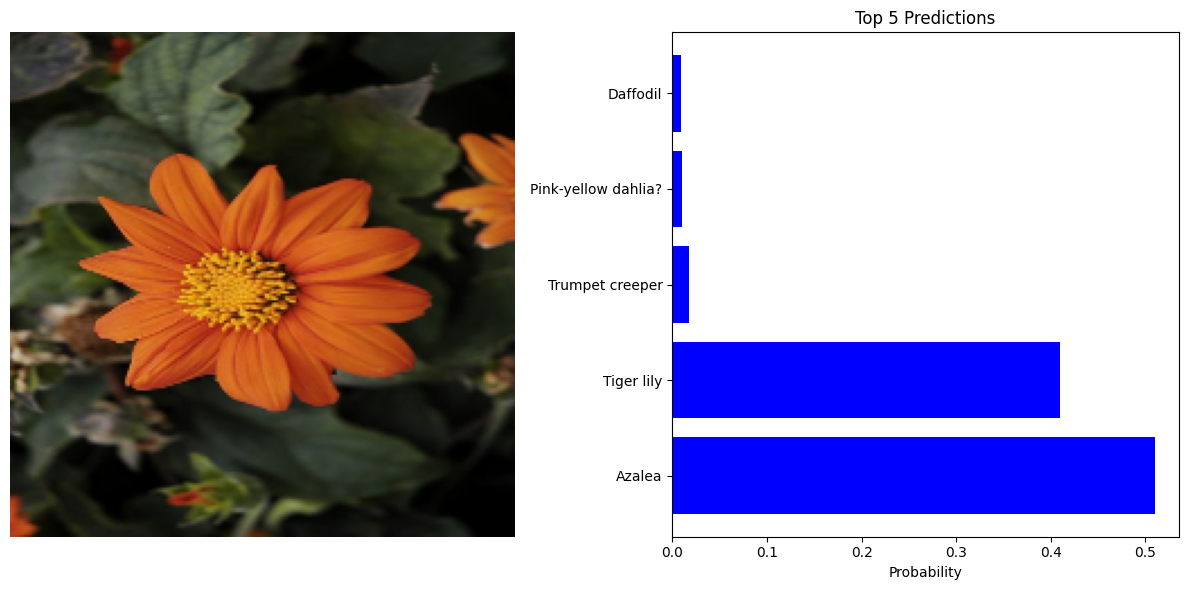

1/1 [==============================] - 0s 32ms/step
[4.3775507947430015e-05, 5.271191548672505e-05, 5.599490032182075e-05, 0.00015089857333805412, 0.9995555281639099]
['Frangipani', 'Bird of paradise', 'Moon orchid', 'Mexican petunia', 'Canterbury bells']
[(4.3775507947430015e-05, 'Frangipani'), (5.271191548672505e-05, 'Bird of paradise'), (5.599490032182075e-05, 'Moon orchid'), (0.00015089857333805412, 'Mexican petunia'), (0.9995555281639099, 'Canterbury bells')]


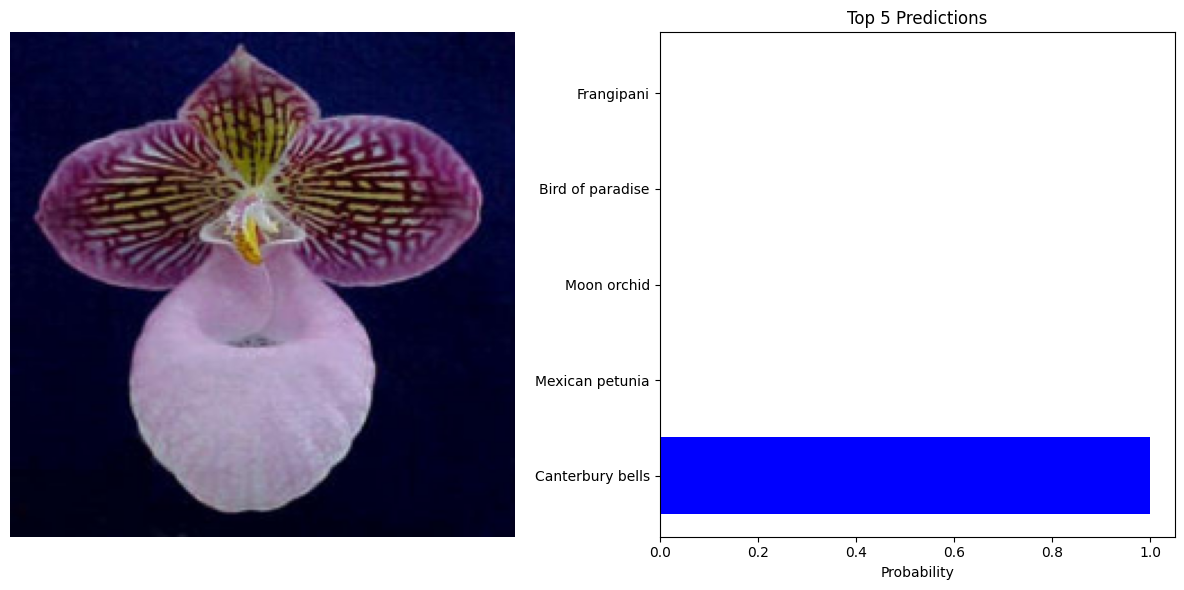

1/1 [==============================] - 0s 41ms/step
[0.0003054020053241402, 0.0005840901867486537, 0.0009015908581204712, 0.0032100770622491837, 0.9939320683479309]
['Lenten rose', 'Marigold', 'Japanese anemone', 'Grape hyacinth', "Colt's foot"]
[(0.0003054020053241402, 'Lenten rose'), (0.0005840901867486537, 'Marigold'), (0.0009015908581204712, 'Japanese anemone'), (0.0032100770622491837, 'Grape hyacinth'), (0.9939320683479309, "Colt's foot")]


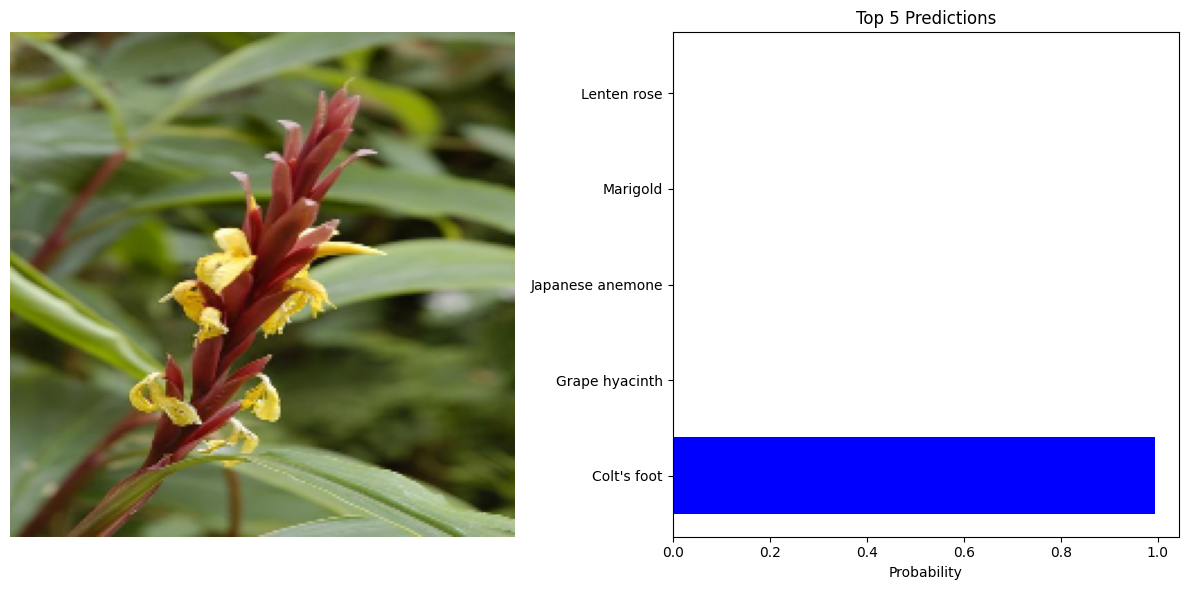

In [23]:
from PIL import Image
image_size = 224
image_path = '/content/hard-leaved_pocket_orchid.jpg'
def predict(image_path, model, top_k, class_names): # Pass class_names as an argument

    image = Image.open(image_path)

    image = np.asarray(image)
    # Change the variable name here to avoid overwriting the Image module
    processed_image = process_image(image)
    image = np.expand_dims(processed_image, axis = 0)



    ps = model.predict(image)[0] #ps is a list of lists, we have only one, we lelect that one

    probabilities = np.sort(ps)[-top_k:len(ps)]
    prbabilities = probabilities.tolist()
    print(prbabilities)
    classes = np.argpartition(ps, -top_k)[-top_k:]
    classes = classes.tolist()
    names = [class_names.get(str(i + 1)).capitalize() for i in (classes)] # Now class_names is accessible
    print(names)


    class_names = [class_names.get(str(i)).capitalize() for i in classes]
    ps_cl = list(zip(prbabilities, names))
    print(ps_cl)
    return probabilities, names

def plot_predictions(image_path, model, class_names, top_k=5): # Pass class_names as an argument
     # Load image
    image = Image.open(image_path)
    image_array = np.array(image)
    processed_image = process_image(image_array)

    # Get the top K predictions
    probs, classes = predict(image_path, model, top_k, class_names) # Pass class_names to predict

    # Plot the image and predictions
    plt.figure(figsize=(12, 6))

    # Plot the image
    plt.subplot(121)
    plt.imshow(processed_image)

    plt.axis('off')

    # Plot the probabilities
    plt.subplot(122)
    plt.barh(classes, probs, color='blue')
    plt.xlabel('Probability')
    plt.title(f'Top {top_k} Predictions')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest probability at the top

    plt.tight_layout()
    plt.show()

# TODO: Plot the input image along with the top 5 classes

images_path = ['/content/wild_pansy.jpg','/content/orange_dahlia.jpg','/content/hard-leaved_pocket_orchid.jpg','/content/cautleya_spicata.jpg']
for image in images_path:
  plot_predictions(image, loaded_Model, class_names, top_k=5) # Pass class_names to plot_predictions